In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet


c:\Users\frank\Desktop\Proyecto_Prediccion_Dengue\Sistema_Prediccion_Dengue\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv("../data/processed/dengue_departamental_semanal_con_fecha.csv")
df["fecha"] = pd.to_datetime(df["fecha"])


In [5]:
df_dep = df[df["departamento"] == "LA LIBERTAD"].copy()


In [6]:
df_dep["fecha"] = pd.to_datetime(df_dep["ano"].astype(str)) + \
                  pd.to_timedelta((df_dep["semana"] - 1) * 7, unit="D")


In [7]:
df_prophet = df_dep[["fecha", "casos_dengue"]].rename(
    columns={"fecha": "ds", "casos_dengue": "y"}
)


In [8]:
modelo = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

modelo.fit(df_prophet)


08:21:09 - cmdstanpy - INFO - Chain [1] start processing
08:21:09 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = modelo.make_future_dataframe(periods=4, freq="W")


In [10]:
forecast = modelo.predict(future)


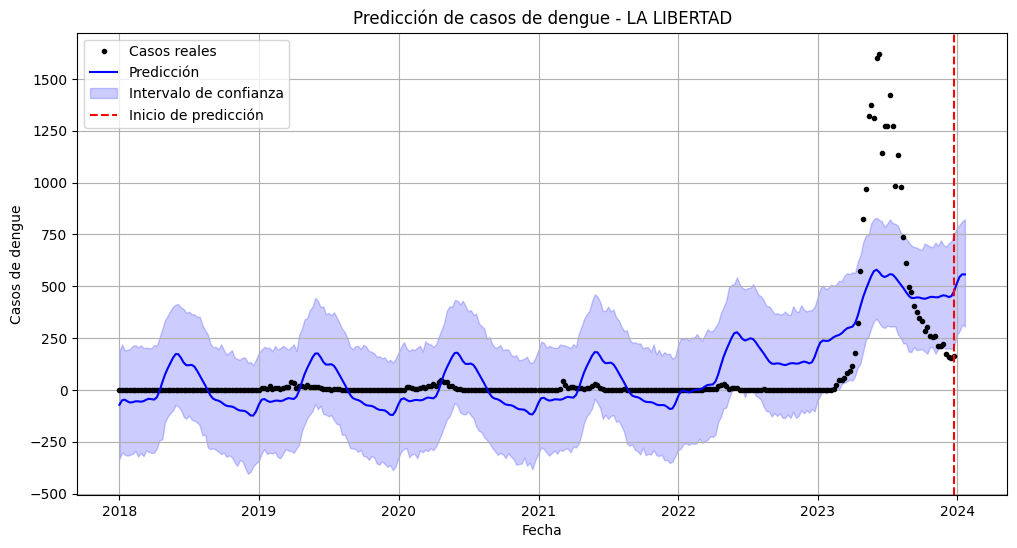

In [11]:
plt.figure(figsize=(12, 6))

# 1. Datos reales (solo hasta 2023)
plt.plot(
    df_prophet["ds"],
    df_prophet["y"],
    "k.",
    label="Casos reales"
)

# 2. Predicción
plt.plot(
    forecast["ds"],
    forecast["yhat"],
    color="blue",
    label="Predicción"
)

# 3. Intervalo de incertidumbre
plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    color="blue",
    alpha=0.2,
    label="Intervalo de confianza"
)

# 4. Línea de inicio de predicción
fecha_corte = df_prophet["ds"].max()
plt.axvline(
    fecha_corte,
    color="red",
    linestyle="--",
    label="Inicio de predicción"
)

plt.title("Predicción de casos de dengue - LA LIBERTAD")
plt.xlabel("Fecha")
plt.ylabel("Casos de dengue")
plt.legend()
plt.grid(True)

plt.show()


In [12]:
media = df_prophet["y"].mean()
desviacion = df_prophet["y"].std()


In [13]:
prediccion_reciente = forecast.tail(4)["yhat"].mean()


In [14]:
def clasificar_riesgo(valor, media, desviacion):
    if valor <= media:
        return "BAJO"
    elif valor <= media + desviacion:
        return "MEDIO"
    elif valor <= media + 2 * desviacion:
        return "ALTO"
    else:
        return "CRÍTICO"


In [15]:
nivel_alerta = clasificar_riesgo(
    prediccion_reciente,
    media,
    desviacion
)

nivel_alerta


'ALTO'

In [16]:
def generar_recomendacion(nivel):
    if nivel == "BAJO":
        return "Monitoreo rutinario y educación preventiva."
    elif nivel == "MEDIO":
        return "Refuerzo de vigilancia epidemiológica."
    elif nivel == "ALTO":
        return "Activar brigadas de control vectorial."
    else:
        return "Declarar alerta sanitaria y acciones inmediatas."


In [17]:
recomendacion = generar_recomendacion(nivel_alerta)
recomendacion


'Activar brigadas de control vectorial.'

In [19]:
def predecir_departamento(nombre_departamento, horizonte=4):
    df_dep = df[df["departamento"] == nombre_departamento].copy()
    
    if df_dep.empty:
        raise ValueError("Departamento no encontrado en el dataset")
    
    df_dep["fecha"] = pd.to_datetime(df_dep["ano"].astype(str)) + \
                      pd.to_timedelta((df_dep["semana"] - 1) * 7, unit="D")
    
    df_prophet = df_dep[["fecha", "casos_dengue"]].rename(
        columns={"fecha": "ds", "casos_dengue": "y"}
    )
    
    modelo = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    modelo.fit(df_prophet)
    
    future = modelo.make_future_dataframe(periods=horizonte, freq="W")
    forecast = modelo.predict(future)
    
    media = df_prophet["y"].mean()
    desviacion = df_prophet["y"].std()
    prediccion_reciente = forecast.tail(horizonte)["yhat"].mean()
    
    nivel = clasificar_riesgo(prediccion_reciente, media, desviacion)
    recomendacion = generar_recomendacion(nivel)
    
    return {
        "departamento": nombre_departamento,
        "nivel_alerta": nivel,
        "recomendacion": recomendacion,
        "media_historica": media,
        "prediccion_futura": prediccion_reciente,
        "df_historico": df_prophet,
        "forecast": forecast
    }


In [20]:
resultado = predecir_departamento("LA LIBERTAD")
resultado


08:43:28 - cmdstanpy - INFO - Chain [1] start processing
08:43:28 - cmdstanpy - INFO - Chain [1] done processing


{'departamento': 'LA LIBERTAD',
 'nivel_alerta': 'ALTO',
 'recomendacion': 'Activar brigadas de control vectorial.',
 'media_historica': np.float64(88.7275641025641),
 'prediccion_futura': np.float64(543.5751634291892),
 'df_historico':             ds    y
 0   2018-01-01    1
 1   2018-01-08    0
 2   2018-01-15    0
 3   2018-01-22    0
 4   2018-01-29    0
 ..         ...  ...
 307 2023-11-26  221
 308 2023-12-03  173
 309 2023-12-10  159
 310 2023-12-17  153
 311 2023-12-24  165
 
 [312 rows x 2 columns],
 'forecast':             ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
 0   2018-01-01  -10.045800 -345.860611  177.704150   -10.045800   -10.045800   
 1   2018-01-08   -9.985982 -293.408192  192.321180    -9.985982    -9.985982   
 2   2018-01-15   -9.926164 -298.792293  217.049635    -9.926164    -9.926164   
 3   2018-01-22   -9.866345 -305.805231  198.674933    -9.866345    -9.866345   
 4   2018-01-29   -9.806527 -315.286835  210.098185    -9.806527    